In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_excel("HousePricePrediction.xlsx")

# Printing first 5 records of the dataset
print(dataset.head(5))

   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  


In [3]:
dataset.shape

(2919, 13)

In [5]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 4
Integer variables: 0
Float variables: 3


Exploratory Data Analysis

<Axes: >

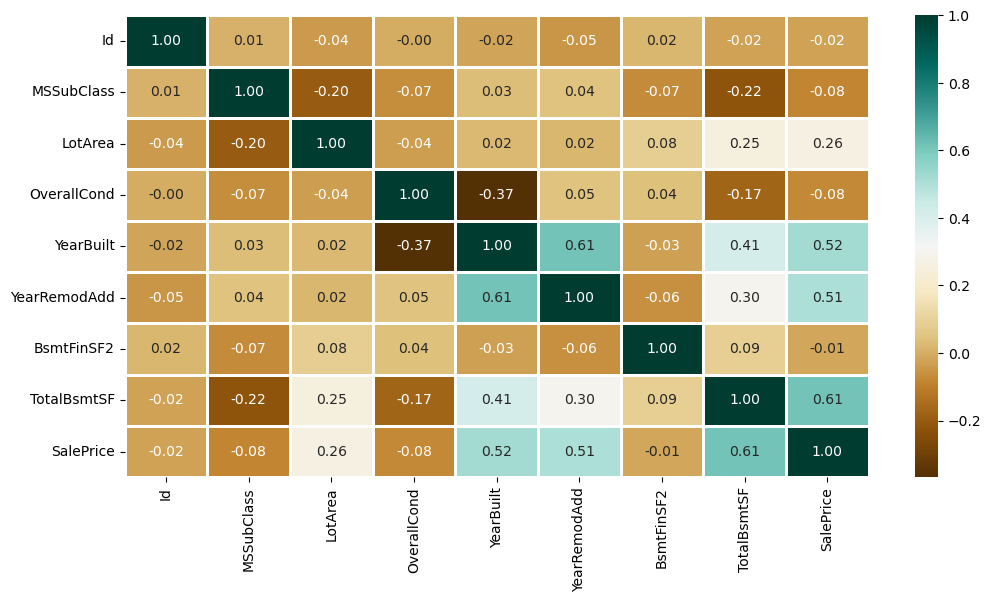

In [9]:
# Select only numerical features for correlation analysis
numerical_dataset = dataset.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

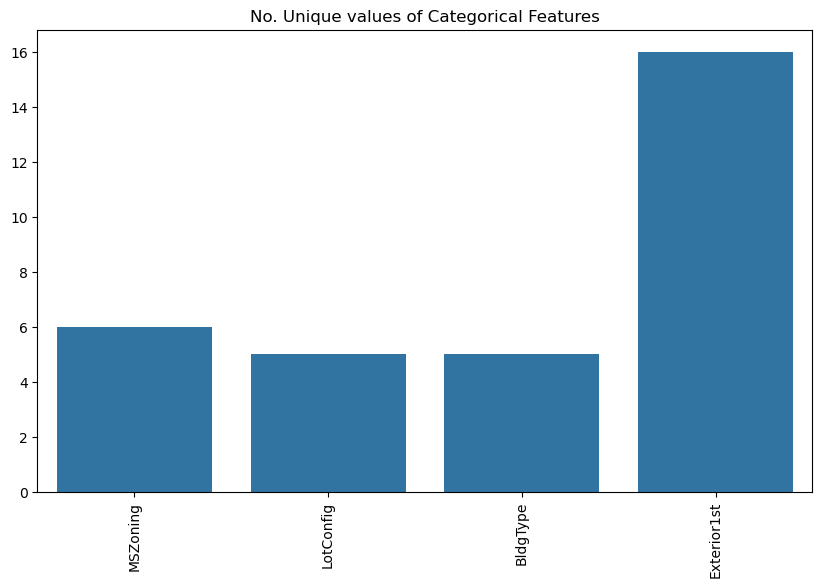

In [11]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)


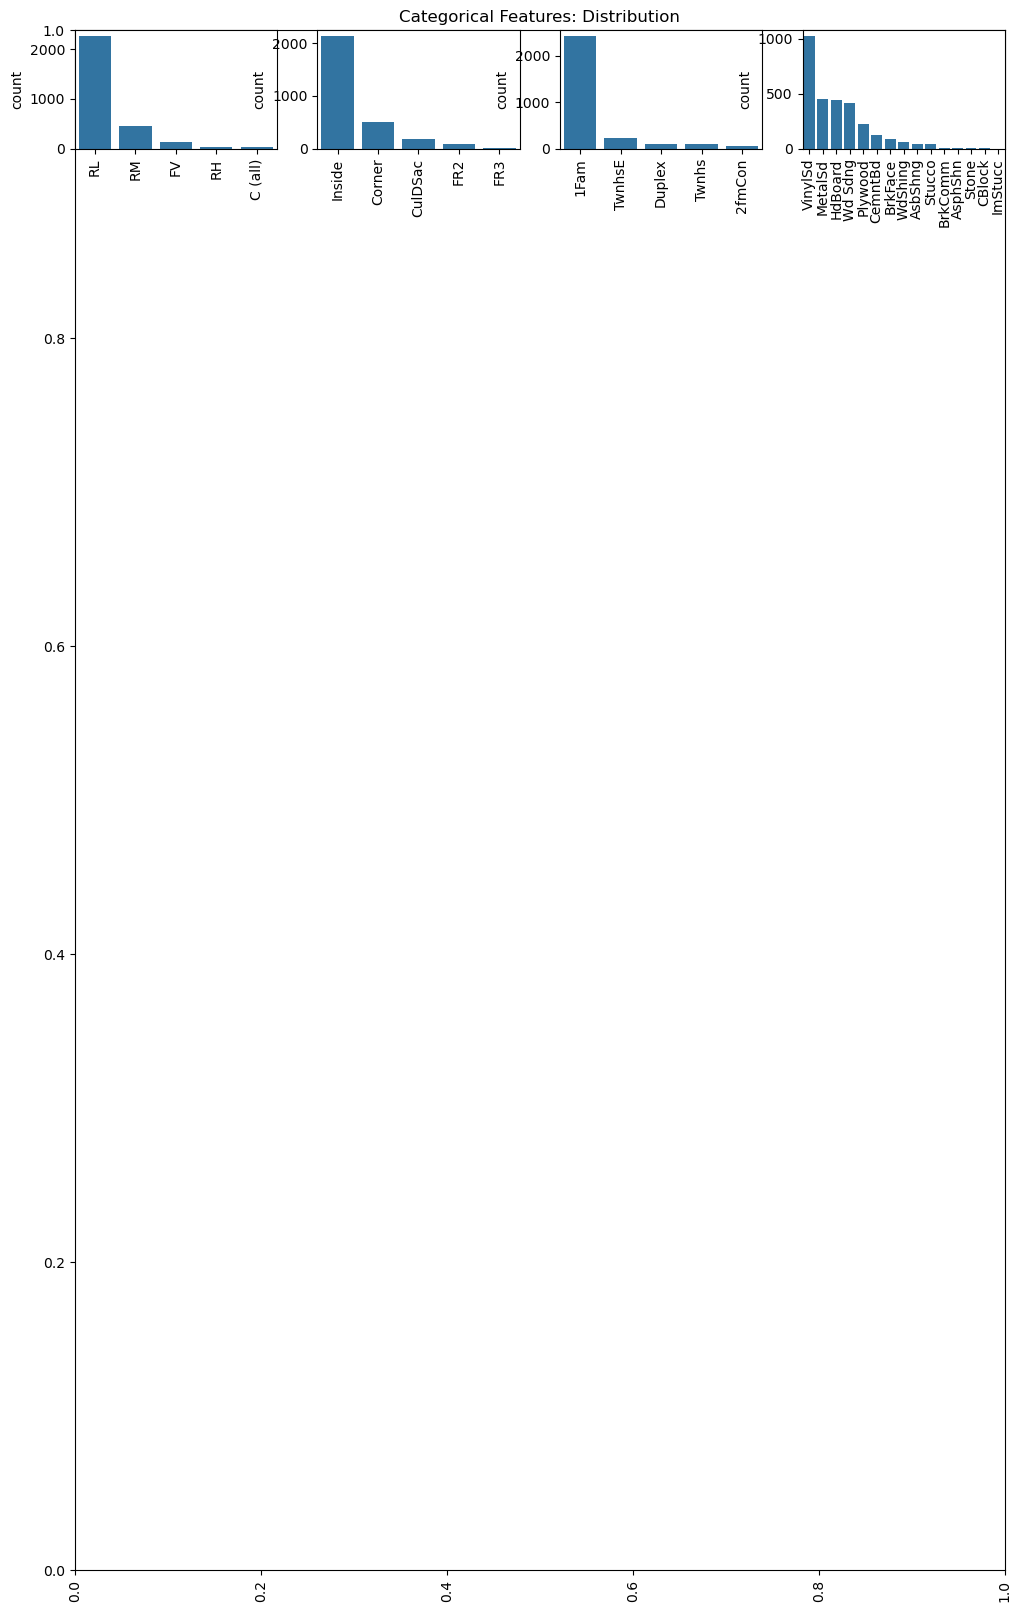

In [25]:
plt.figure(figsize=(12, 20))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

Data Cleaning

In [42]:
dataset.drop(['Id'],
             axis=1,
             inplace=True)

KeyError: "['Id'] not found in axis"

In [44]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(
  dataset['SalePrice'].mean()) 


In [46]:
new_dataset = dataset.dropna()


In [48]:
new_dataset.isnull().sum()


MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64

In [64]:
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ', 
      len(object_cols))


Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of. categorical features:  4


In [68]:
OH_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)



TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [70]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

# Split the training set into 
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [72]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1870512931870423


In [74]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

mean_absolute_percentage_error(Y_valid, Y_pred)

0.18813836034159534

In [88]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.18741683841600051


In [104]:

from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

cb_model = CatBoostRegressor()
cb_model.fit(X_train, Y_train)
preds = cb_model.predict(X_valid) 

cb_r2_score=r2_score(Y_valid, preds)
cb_r2_score

Learning rate set to 0.046797
0:	learn: 56473.5753002	total: 169ms	remaining: 2m 48s
1:	learn: 55780.1567575	total: 174ms	remaining: 1m 26s
2:	learn: 55060.9599505	total: 180ms	remaining: 59.8s
3:	learn: 54456.1126921	total: 187ms	remaining: 46.7s
4:	learn: 53901.1464265	total: 195ms	remaining: 38.8s
5:	learn: 53334.6062357	total: 199ms	remaining: 33s
6:	learn: 52824.4943646	total: 204ms	remaining: 28.9s
7:	learn: 52381.4267520	total: 208ms	remaining: 25.7s
8:	learn: 51841.0364316	total: 211ms	remaining: 23.2s
9:	learn: 51281.5852560	total: 215ms	remaining: 21.3s
10:	learn: 50825.3817438	total: 218ms	remaining: 19.6s
11:	learn: 50477.2609796	total: 221ms	remaining: 18.2s
12:	learn: 50081.4097641	total: 225ms	remaining: 17s
13:	learn: 49663.6380360	total: 228ms	remaining: 16s
14:	learn: 49334.5782662	total: 231ms	remaining: 15.2s
15:	learn: 48967.5221026	total: 234ms	remaining: 14.4s
16:	learn: 48676.4063222	total: 237ms	remaining: 13.7s
17:	learn: 48359.1169955	total: 240ms	remaining: 

0.38351169878113034